## Distilling the Knowledge in a Neural Network

Paper Url: https://arxiv.org/pdf/1503.02531.pdf

In [0]:
from IPython.display import Image

### 1 Introduction
#### 1.1 Motivation
This tutorial will introduce how distilling the knowledge from a cumbersome and comprehensive neural network works. Specifically, it will show how distillation using soft targets can transfer a great deal of knowledge to the distilled model and that the distilled model performs better than the compressed model simply using the hard labels.

In the ideal world, one way of improving the performance of machine learning models is to train
a model with a large amount of data with appropriate regularizations, so that the model can generalize well on unseen data. However, this big model is computationally expensive and cumbersome to use. On the other hand, if we choose to use smaller models, they usually cannot capture many complex features that the more complex model can easily capture. 

The motivation for distilling the knowledge approach is that we would like to have a smaller model that learns the knowledge from the cumbersome model, demonstrates improved performances compared to typical smaller models, and is more suitable for deployment. In other words, we want to build a model that learns most of the generalizations from the cumbersome model and still is lighter. 

The big, cumbersome model is often called a "teacher" model and the smaller model that distills knoweldge from the teacher model is often called a "student" model. 

A "teacher" model assigns the biggest probability to the corect answer and relatively low probabilities to incorrect answers. The relative probabilities of incorrect answers show how the model tends to generalize. For example, an image of a Dog may have a very small chance of being mistaken for a Cat, but it is more likely than being mistaken for a Truck. 

A "student" model is trained to mimic a pre-trained, large, and cumbersome model. The following image is a simple explanation of how "teacher" transfers knowledge to "student".


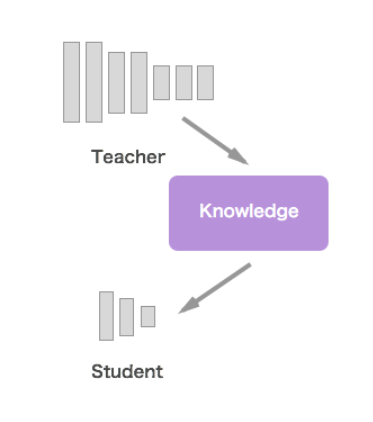

In [0]:
Image('distill.PNG')


In distillation, instead of copying the weights or simplifying them, the objective is to train a smaller model on a transfer set and use a “soft target” distribution for each case in the transfer set. For this transfer stage, we use the same training set or a separate "transfer" set used for training the "teacher" model. The "student" model learns from the knowledge produced after training the "teacher" model with a high temperature in its softmax.

#### 1.2 Insight
In general, knowledge distillation is a simple and effective approach to remedying the insufficient supervised information (labels) in classification problem. In traditional classification problem, the target of model is to map all potential features to one discrete point in output space, such as one-hot encoding. Thus, with cross entropy, the information this point is able to provide would only be $\log(\text{# of classes})$. Nevertheless, with techniques of knowledge distillation, we can obtain a continuous distribution of labels from every sample, which offers more information than one-hot encoding, and also keeps the variance in classes and distance among classes.

Therefore, we can regard knowledge distillation as an elegant technique for data augmentation, which would be very helpful for generalization. We know some other generalization methods in deep learning, such as dropout, L2 regularization, pre-train, etc. The intuition of knowledge distillation and pre-train are sort of similar, which want to incorporate some prior knowledge into neural networks.


### 2 How Distillation Works: Using Softmax and Temperature
Neural networks typically produce class probabilitties by using a "softmax" output layer that converts the logit (the inputs to the final softmax), $z_i$, computed for each class into a probability, $q_i$, by comparing $z_i$ with the other logits. Softmax function is commonly used for an output layer of neural networks, since it assigns probabilities for each label and the all probabilities add up to 1. It basically outputs a probability distribution of different labels. For the MNIST dataset, similarly, a softmax layer trained on the hand-written digits assign a separate probability for each of the ten digits and the probabilities add up to 1.   


$$
q_i = \frac{exp(z_i)}{\sum_j exp(z_i)}
$$

If distillation is incorporated, 

$$
q_i = \frac{exp(z_i/T)}{\sum_j exp(z_j/T)}
$$

where T is a temperature, normally set to 1. If the value of T is big, all actions have nearly the same probability. Using a higher T produces a softer probability distribution over classes. On the other hand, if value of T is small, the more expected rewards affect the probability. For a lower T, the probability of the action with the highest expected reward tends to become 1.

In distillation, we raise the temperature of the final softmax layer until the cumbersome model produces a suitably soft set of targets, where the probability is well-distributed across different labels. If we do not raise the temperature, the cumbersome model ("teacher") is likely to assign probability close to 1 to a single label and 0 to all the other labels. In that case, a "student" model will obtain information only about the one dominating label and not be able to obtain information from all the other labels.    

A soft target approach is useful for a "student" model to effectively pick up the knowledge being transferred from a "teacher" model, since it can learn from each probability assigned to each label. For example, when the soft targets have high entropy, they tend to provide much more information than hard targets where classes are one-hot encoded (1 for the correct label and 0 for the other labels). 

In this tutorial, we train the distilled model both with soft targets and hard targets (correct labels). Specifically, we use a weighted average of two different objective functions based on soft targets and hard targets, respectively, which can be regarded as a multi-task learning problem. 

The first objective function $\mathcal{L}_{soft}$ is the cross entropy with the soft targets and this cross entropy is computed using the same high temperature in the softmax of the distilled model as was used for generating the soft targets from the cumbersome model.

$$\mathcal{L}_{soft}=-\sum_{i=1}^{K}p_i\log q_i.$$

where $p_i$ is the soft target from teacher model and $q_i$ is the softmax output from the student model. 

The second objective function $\mathcal{L}_{hard}$ is the traditional cross entropy with the correct labels. This is computed using exactly the same logits in softmax of the distilled model but at a temperature of 1.

Thus, we can get the final objective function is

$$\mathcal{L}=\mathcal{L}_{hard} + \lambda\mathcal{L}_{soft}.$$

where $\lambda$ is the weight we assign for soft targets. Since the magnitudes of the gradients produced by the soft targets scale as $1/T^2$ it is important to multiply them by $T^2$ when using both hard and soft targets. In general, we should assign a larget weight to $\mathcal{L}_{soft}$.

After the student model has been trained (distilled as well), it uses a temperature of 1.

### 3 Data: MNIST and CIFAR-10

We used two datasets for this tutorial: MNIST and CIFAR-10, since they are well-known datasets being widely used for training neural networks and easily accessible within Keras and Tensorflow platform. 

MNIST (Modified National Institute of Standards and Technology database) is a large database of 10 handwritten digits from 0 to 9. Being widely used in the paper, MNIST dataset contains 60,000 training images used for training the model and 10,000 testing images used for measuring the performance of the model on unseen test sets. Each image is 28 X 28 pixels, which can be interpreted as a big array of numbers. In this tutorial, we flattened this array into a vector of 28X28 = 784 numbers.

CIFAR-10 dataset (Canadian Institute For Advanced Research) consists of a collection of images - airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck - in 10 classes, with 6000 images per class. It contains 50,000 training images and 10,000 test images. Each image is 32X32 color images, which can also be interpreted as a big array of numbers.   

### 4 Implementations of Knowledge Distillation on MNIST
#### 4.1 Fully-Connected Neural Networks
First, in order to test distilliation on MNIST dataset, we utilized Tensorflow to implement the simple fully-connected neural networks in Section 3 in the original paper. The teacher network has two hidden layers with 1200 rectified linear hidden units at each layer, 50% dropout rate and L2 norm constraints with $l=15$ (presented in [G. E. Hinton, et al](https://arxiv.org/pdf/1207.0580.pdf)). The student network has two hidden layers with 800 rectified linear hidden units in each layer and no regularzation applied.

In [0]:
import tensorflow as tf
import numpy as np
import tensorflow.contrib.slim as slim
import keras
from tensorflow.examples.tutorials.mnist import input_data


def FCNetwork(input, dropout_rate=0.5, num_units=1200, scope='teacher',reuse = False):
    with tf.variable_scope(scope,reuse = reuse) as sc :
        with slim.arg_scope([slim.fully_connected],biases_initializer=tf.constant_initializer(0.0),activation_fn=tf.nn.relu): 
            net = slim.fully_connected(input, num_units, scope='fc1')
            if scope == 'teacher':
                net = tf.nn.dropout(net, dropout_rate)
            net = slim.fully_connected(net, num_units, scope='fc2')
            if scope == 'teacher':
                net = tf.nn.dropout(net, dropout_rate)
            net = slim.fully_connected(net, 10, activation_fn=None,scope='fc3')
            return net

def loss(prediction, output):
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=output, logits=prediction)) # cross entropy                                           
    correct_prediction = tf.equal(tf.argmax(tf.nn.softmax(prediction),1), tf.argmax(output,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return cross_entropy, accuracy

Using TensorFlow backend.


#### 4.2 Training, Test, and Distillation on MNIST
We adopted gradient descent to optimize the model and set learning rate to 0.3. Also, we found out that the distilled student network needs more epochs to converge, so we ran 30k iterations for teacher network and 100k iterations for both distilled and undistilled student network. The batch size is set to 128 for both teacher and student networks. While traning both the cumbersome model and the smaller model, the tempature is set to 10 in order to produce a softer probability distribution over classes after experimenting on different parameters. Also, we assigned considerably low weight for hard target function (see details in code).


In [0]:
def runDistillationMNIST(verbose=True, print_every=1000, teacher_iters=30000, student_iters=100000, \
                         batch_size=128, lr=0.4, teacher_num_units=1200, student_num_units=800, \
                         temperature=10, lam=10, keep_prob=0.5, l=15):
    with tf.Graph().as_default():
        # load data
        mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)  

        # placeholder
        x = tf.placeholder(tf.float32, shape=[None, 784])
        y_ = tf.placeholder(tf.float32, shape=[None, 10])
        dropout_rate = tf.placeholder(tf.float32)

        # network output and divided by t
        y_teacher = FCNetwork(x, dropout_rate, teacher_num_units, scope='teacher')
        y_student = FCNetwork(x, num_units=student_num_units, scope='student')
        y_teacher_t = y_teacher/temperature
        y_student_t = y_student/temperature

        # loss and acc
        cross_entropy_teacher, accuracy_teacher = loss(y_teacher, y_)
        student_loss1, _ = loss(y_student_t, tf.nn.softmax(y_teacher_t))
        student_loss2, accuracy_student = loss(y_student, y_)
        cross_entropy_student = (temperature**2 * lam * student_loss1 + student_loss2) / (temperature**2 * lam + 1)

        # get vars and gradients
        model_vars = tf.trainable_variables()
        var_teacher = [var for var in model_vars if 'teacher' in var.name]
        var_student = [var for var in model_vars if 'student' in var.name]
        grad_teacher = tf.gradients(cross_entropy_teacher,var_teacher)
        
        # add coonstraints on teacher nn
        grad_teacher = [tf.clip_by_norm(g, clip_norm=l, axes=0) for g in grad_teacher] 
        grad_student = tf.gradients(cross_entropy_student,var_student)

        # use gradient descent
        trainer_teacher = tf.train.GradientDescentOptimizer(lr)
        trainer_student = tf.train.GradientDescentOptimizer(lr)
        step_teacher = trainer_teacher.apply_gradients(zip(grad_teacher,var_teacher))
        step_student = trainer_student.apply_gradients(zip(grad_student,var_student))

        # sess
        sess = tf.InteractiveSession()
        sess.run(tf.global_variables_initializer())

        # train and test teacher network
        for i in range(teacher_iters):
            batch = mnist.train.next_batch(batch_size)
            if i% print_every == 0:
                train_acc_teacher = accuracy_teacher.eval(feed_dict={x:batch[0], y_: batch[1],dropout_rate: 1.0})
                print("step %d, training accuracy %f"%(i, train_acc_teacher))
            step_teacher.run(feed_dict={x: batch[0], y_: batch[1], dropout_rate: keep_prob})

        test_acc_teacher = sess.run(accuracy_teacher, feed_dict={x:mnist.test.images, y_: mnist.test.labels, dropout_rate: 1.0})
        print("test accuracy of the teacher model is %f"%(test_acc_teacher))

        # train and test student network
        for i in range(student_iters):
            batch = mnist.train.next_batch(batch_size)
            if i% print_every == 0:
                train_acc_student = accuracy_student.eval(feed_dict={x:batch[0], y_: batch[1],dropout_rate: 1.0})
                print("step %d, training accuracy %f"%(i, train_acc_student))
            step_student.run(feed_dict={x: batch[0], y_: batch[1],dropout_rate: 1.0}) 

        test_acc_student = sess.run(accuracy_student, feed_dict={x:mnist.test.images, y_: mnist.test.labels, dropout_rate: 1.0})
        print("test accuracy of the student model is %f"%(test_acc_student))
        
        return test_acc_teacher, test_acc_student

In [0]:
test_acc_teacher, test_acc_student = runDistillationMNIST()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


step 0, training accuracy 0.054688
step 1000, training accuracy 0.984375
step 2000, training accuracy 0.984375
step 3000, training accuracy 1.000000
step 4000, training accuracy 0.992188
step 5000, training accuracy 0.992188
step 6000, training accuracy 0.992188
step 7000, training accuracy 0.992188
step 8000, training accuracy 0.992188
step 9000, training accuracy 1.000000
step 10000, training accuracy 1.000000
step 11000, training accuracy 1.000000
step 12000, training accuracy 0.992188
step 13000, training accuracy 1.000000
step 14000, training accuracy 1.000000
step 15000, training accuracy 1.000000
step 16000, training accuracy 1.000000
step 17000, training accuracy 1.000000
step 18000, training accuracy 1.000000
step 19000, training accuracy 1.000000
step 20000, training accuracy 1.000000
step 21000, training accuracy 1.000000
step 22000, training accuracy 0.992188
step 23000, training accuracy 1.000000
step 24000, training accuracy 1.000000
step 25000, training accuracy 1.000000

In [0]:
def runMNIST(verbose=True, print_every=1000, iters=100000, scope='teacher', num_hidden_units=1200, keep_prob=0.5, batch_size=128, lr=0.4):
    with tf.Graph().as_default():
        # load data
        mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)  

        # placeholder
        x = tf.placeholder(tf.float32, shape=[None, 784])
        y_ = tf.placeholder(tf.float32, shape=[None, 10])

        # network output and divided by t       
        y = FCNetwork(x, keep_prob, num_hidden_units, scope=scope)
 
        # loss and acc
        cross_entropy, accuracy = loss(y, y_)

        # use gradient descent to optimize
        train_step = tf.train.GradientDescentOptimizer(lr).minimize(cross_entropy)

        # sess
        sess = tf.InteractiveSession()
        sess.run(tf.global_variables_initializer())

        # train and test student network
        for i in range(iters):
            batch = mnist.train.next_batch(batch_size)
            if i% print_every == 0:
                train_acc = accuracy.eval(feed_dict={x:batch[0], y_: batch[1]})
                print("step %d, training accuracy %f"%(i, train_acc))
            train_step.run(feed_dict={x: batch[0], y_: batch[1]}) 

        test_acc = sess.run(accuracy, feed_dict={x:mnist.test.images, y_: mnist.test.labels})
        print("test accuracy of the student model is %f"%(test_acc))
        
        return test_acc

In [0]:
test_student_only_acc = runMNIST(scope='student', num_hidden_units=800)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


step 0, training accuracy 0.093750
step 1000, training accuracy 0.984375
step 2000, training accuracy 0.992188
step 3000, training accuracy 0.992188
step 4000, training accuracy 0.992188
step 5000, training accuracy 1.000000
step 6000, training accuracy 1.000000
step 7000, training accuracy 1.000000
step 8000, training accuracy 1.000000
step 9000, training accuracy 1.000000
step 10000, training accuracy 1.000000
step 11000, training accuracy 1.000000
step 12000, training accuracy 1.000000
step 13000, training accuracy 1.000000
step 14000, training accuracy 1.000000
step 15000, training accuracy 1.000000
step 16000, training accuracy 1.000000
step 17000, training accuracy 1.000000
step 18000, training accuracy 1.000000
step 19000, training accuracy 1.000000
step 20000, training accuracy 1.000000
step 21000, training accuracy 1.000000
step 22000, training accuracy 1.000000
step 23000, training accuracy 1.000000
step 24000, training accuracy 1.000000
step 25000, training accuracy 1.000000

#### 4.3 Results and Limitations
Our replication results align with the main point of the paper: while the cumbersome model achieves the high test accuracy, distilled student network with soft target performs better than undistilled student network with hard targets. 

The results we got are:
<ul>
    <li> Test accuracy of teacher network: <b>98.76%</b> (<b>124</b> errors in 10000 test samples).</li>
    <li> Test accuracy of distilled student network: <b>98.59%</b> (<b>141</b> errors in 10000 test samples).</li>
     <li> Test accuracy of undistilled student network: <b>98.36%</b> (<b>164</b> errors in 10000 test samples).</li>
</ul>

Under such pararmeter setting, we could not exactly replicate the results presented in paper, `teacher network produces 67 test errors, undistilled student network achieves 146 errors and distilled student network achieves 74 test errors`. This is partly because we do not know the best choice for lots of hyperparameters, such as $\lambda$ (the weight we assign to hard target function), the learning rate, the batch size, etc. In addition, based on the computation resource we have, it took too much time to do cross-validation.

However, as seen from the results above, we successfully showed that the distilled student network performs better than undistilled student network (the model with hard targets) on test dataset.


#### 4.4 Distillation on Incomplete MNIST
As mentioned on paper, we can remove digit 3 in the training set to see whether distillation can help capture underlying information in soft targets, which should make model give better performance while testing. 

The results we got are:
<ul>
    <li> Test accuracy of teacher network: <b>88.73%</b>.</li>
    <li> Test accuracy of distilled student network: <b>88.69%</b>.</li>
     <li> Test accuracy of undistilled student network: <b>88.56%</b>.</li>
</ul>

Again, distilled student generalize better to unseen data, digit 3 class, than undistilled student network.




In [0]:
def batch_idx(b, n, i):
    if b >= n:
        return np.arange(n)
    idx1 = (i*b)%n
    idx2 = ((i+1)*b)%n
    if idx2 < idx1:
        idx1 -= n
    return np.arange(idx1, idx2)
    
def runDistillationMNISTWithoutDigits(numbers, verbose=True, print_every=1000, teacher_iters=30000, student_iters=100000, \
                         batch_size=128, lr=0.4, teacher_num_units=1200, student_num_units=800, \
                         temperature=10, lam=10, keep_prob=0.5, l=15):
    with tf.Graph().as_default():
        # load data
        mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
        train_images = np.array([x for (x,y) in zip(mnist.train.images, mnist.train.labels) if np.all(y[numbers]==0)])
        train_labels = np.array([y for (x,y) in zip(mnist.train.images, mnist.train.labels) if np.all(y[numbers]==0)])
        n = train_images.shape[0]

        # placeholder
        x = tf.placeholder(tf.float32, shape=[None, 784])
        y_ = tf.placeholder(tf.float32, shape=[None, 10])
        dropout_rate = tf.placeholder(tf.float32)

        # network output and divided by t
        y_teacher = FCNetwork(x, dropout_rate, teacher_num_units, scope='teacher')
        y_student = FCNetwork(x, num_units=student_num_units, scope='student')
        y_teacher_t = y_teacher/temperature
        y_student_t = y_student/temperature

        # loss and acc
        cross_entropy_teacher, accuracy_teacher = loss(y_teacher, y_)
        student_loss1, _ = loss(y_student_t, tf.nn.softmax(y_teacher_t))
        student_loss2, accuracy_student = loss(y_student, y_)
        cross_entropy_student = (temperature**2 * lam * student_loss1 + student_loss2) / (temperature**2 * lam + 1)

        # get vars and gradients
        model_vars = tf.trainable_variables()
        var_teacher = [var for var in model_vars if 'teacher' in var.name]
        var_student = [var for var in model_vars if 'student' in var.name]
        grad_teacher = tf.gradients(cross_entropy_teacher,var_teacher)
        
        # add coonstraints on teacher nn
        grad_teacher = [tf.clip_by_norm(g, clip_norm=l, axes=0) for g in grad_teacher] 
        grad_student = tf.gradients(cross_entropy_student,var_student)

        # use gradient descent
        trainer_teacher = tf.train.GradientDescentOptimizer(lr)
        trainer_student = tf.train.GradientDescentOptimizer(lr)
        step_teacher = trainer_teacher.apply_gradients(zip(grad_teacher,var_teacher))
        step_student = trainer_student.apply_gradients(zip(grad_student,var_student))

        # sess
        sess = tf.InteractiveSession()
        sess.run(tf.global_variables_initializer())

        # train and test teacher network
        for i in range(teacher_iters):
            batch = batch_idx(batch_size, n, i)
            batch_x = train_images[batch,:]
            batch_y = train_labels[batch,:]
            if i% print_every == 0:
                train_acc_teacher = accuracy_teacher.eval(feed_dict={x: batch_x, y_: batch_y, dropout_rate: 1.0})
                print("step %d, training accuracy %f"%(i, train_acc_teacher))
            step_teacher.run(feed_dict={x: batch_x, y_: batch_y, dropout_rate: keep_prob})

        test_acc_teacher = sess.run(accuracy_teacher, feed_dict={x: mnist.test.images, y_: mnist.test.labels, dropout_rate: 1.0})
        print("test accuracy of the teacher model is %f"%(test_acc_teacher))

        # train and test student network
        for i in range(student_iters):
            batch = batch_idx(batch_size, n, i)
            batch_x = train_images[batch,:]
            batch_y = train_labels[batch,:]
            if i% print_every == 0:
                train_acc_student = accuracy_student.eval(feed_dict={x: batch_x, y_: batch_y, dropout_rate: 1.0})
                print("step %d, training accuracy %f"%(i, train_acc_student))
            step_student.run(feed_dict={x: batch_x, y_: batch_y, dropout_rate: 1.0}) 

        test_acc_student = sess.run(accuracy_student, feed_dict={x:mnist.test.images, y_: mnist.test.labels, dropout_rate: 1.0})
        print("test accuracy of the student model is %f"%(test_acc_student))
        
        return test_acc_teacher, test_acc_student

In [0]:
test_acc_teacher1, test_acc_student1 = runDistillationMNISTWithoutDigits([3])

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py fr

In [0]:
def runMNISTWithoutDigits(numbers, verbose=True, print_every=1000, iters=100000, scope='teacher', num_hidden_units=1200, keep_prob=0.5, batch_size=128, lr=0.4):
    with tf.Graph().as_default():
        # load data
        mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
        train_images = np.array([x for (x,y) in zip(mnist.train.images, mnist.train.labels) if np.all(y[numbers]==0)])
        train_labels = np.array([y for (x,y) in zip(mnist.train.images, mnist.train.labels) if np.all(y[numbers]==0)])
        n = train_images.shape[0]

        # placeholder
        x = tf.placeholder(tf.float32, shape=[None, 784])
        y_ = tf.placeholder(tf.float32, shape=[None, 10])

        # network output and divided by t       
        y = FCNetwork(x, keep_prob, num_hidden_units, scope=scope)
 
        # loss and acc
        cross_entropy, accuracy = loss(y, y_)

        # use gradient descent to optimize
        train_step = tf.train.GradientDescentOptimizer(lr).minimize(cross_entropy)

        # sess
        sess = tf.InteractiveSession()
        sess.run(tf.global_variables_initializer())

        # train and test student network
        for i in range(iters):
            batch = batch_idx(batch_size, n, i)
            batch_x = train_images[batch,:]
            batch_y = train_labels[batch,:]
            if i% print_every == 0:
                train_acc = accuracy.eval(feed_dict={x:batch_x, y_: batch_y})
                print("step %d, training accuracy %f"%(i, train_acc))
            train_step.run(feed_dict={x: batch_x, y_: batch_y}) 

        test_acc = sess.run(accuracy, feed_dict={x:mnist.test.images, y_: mnist.test.labels})
        print("test accuracy of the student model is %f"%(test_acc))
        
        return test_acc

In [0]:
test_student_only1 = runMNISTWithoutDigits([3], scope='student', num_hidden_units=800)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


step 0, training accuracy 0.070312
step 1000, training accuracy 0.968750
step 2000, training accuracy 1.000000
step 3000, training accuracy 1.000000
step 4000, training accuracy 1.000000
step 5000, training accuracy 1.000000
step 6000, training accuracy 1.000000
step 7000, training accuracy 1.000000
step 8000, training accuracy 1.000000
step 9000, training accuracy 1.000000
step 10000, training accuracy 1.000000
step 11000, training accuracy 1.000000
step 12000, training accuracy 1.000000
step 13000, training accuracy 1.000000
step 14000, training accuracy 1.000000
step 15000, training accuracy 1.000000
step 16000, training accuracy 1.000000
step 17000, training accuracy 1.000000
step 18000, training accuracy 1.000000
step 19000, training accuracy 1.000000
step 20000, training accuracy 1.000000
step 21000, training accuracy 1.000000
step 22000, training accuracy 1.000000
step 23000, training accuracy 1.000000
step 24000, training accuracy 1.000000
step 25000, training accuracy 1.000000

### 5. Implementations of Knowledge Distillation on CIFAR-10
#### 5.1 Reinvented LeNet-5

We ran similar tests to CIFAR-10 datasets. First, in order to test distilliation on CIFAR-10 dataset, we utilized Tensorflow to implement simplest convolution neural network - LeNet-5 as the teacher model. Here we reinvent the architecture of LeNet for better demonstration of knowledge distillation. Specifically, we substitute the second last fully-connected layer in the original LeNet with the feed-forward network (two hidden layers) we use in MNIST test. The number of hidden units in each fully-connected layer is still set to 1200. We continue using dropout with $p=0.5$ for regularization but discard the constriant on weights because it's hard to cross-validate. Besides, we add ReLU for all layers in network except the output layer.

The reinvented network architechture is shown below:

<table>
    <thead>
        <tr>
            <th colspan=2>Layer 1</th>
            <th>Feature Map</th>
            <th>Size</th>
            <th>Kernel Size</th>
            <th>Stride</th>
            <th>Activation</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>Input</td>
            <td>Image</td>
            <td>1</td>
            <td>32x32</td>
            <td>-</td>
            <td>-</td>
             <td>-</td>
        </tr>
        <tr>
            <td>1</td>
            <td>Convolution</td>
            <td>6</td>
            <td>28x28</td>
            <td>5x5</td>
            <td>1</td>
             <td>ReLU</td>
        </tr>
        <tr>
            <td>2</td>
            <td>Pooling</td>
            <td>6</td>
            <td>14x14</td>
            <td>2x2</td>
            <td>2</td>
             <td>ReLU</td>
        </tr>
        <tr>
            <td>3</td>
            <td>Convolution</td>
            <td>16</td>
            <td>10x10</td>
            <td>5x5</td>
            <td>1</td>
             <td>ReLU</td>
        </tr>
        <tr>
            <td>4</td>
            <td>Pooling</td>
            <td>16</td>
            <td>5x5</td>
            <td>2x2</td>
            <td>2</td>
             <td>ReLU</td>
        </tr>
         <tr>
            <td>5</td>
            <td>Convolution</td>
            <td>120</td>
            <td>1x1</td>
            <td>5x5</td>
            <td>1</td>
             <td>ReLU</td>
        </tr>
         <tr>
            <td>6</td>
            <td>Fully-Connected</td>
            <td>-</td>
            <td>1200</td>
            <td>-</td>
            <td>-</td>
             <td>ReLU</td>
        </tr>
         <tr>
            <td>7</td>
            <td>Fully-Connected</td>
            <td>-</td>
            <td>1200</td>
            <td>-</td>
            <td>-</td>
             <td>ReLU</td>
        </tr>
         <tr>
            <td>Output</td>
            <td>Fully-Connected</td>
            <td>-</td>
            <td>10</td>
            <td>-</td>
            <td>-</td>
             <td>Softmax</td>
        </tr>
    </tbody>
</table>
<br>

We still used simple fully-connected neural networks with 800 units in two hidden layers  as the student model and no regularization applied.

In [0]:
def LeNet(input, dropout_rate=0.5, num_units=1200, scope='teacher',reuse = False):
    with tf.variable_scope(scope,reuse = reuse) as sc :
        with slim.arg_scope([slim.conv2d], padding='VALID',
                            activation_fn=tf.nn.relu,
                            weights_initializer=tf.truncated_normal_initializer(stddev=0.01),
                            weights_regularizer=slim.l2_regularizer(0.0005)):
            net = slim.conv2d(input,6,[5,5],1,padding='SAME',scope='conv1')
            net = slim.max_pool2d(net, [2, 2], scope='pool2')
            net = slim.conv2d(net,16,[5,5],1,scope='conv3')
            net = slim.max_pool2d(net, [2, 2], scope='pool4')
            net = slim.conv2d(net,120,[5,5],1,scope='conv5')
            net = slim.flatten(net, scope='flat6')
            net = slim.fully_connected(net, num_units, scope='fc7')
            if scope == 'teacher':
                net = tf.nn.dropout(net, dropout_rate)
            net = slim.fully_connected(net, num_units, scope='fc8')
            if scope == 'teacher':
                net = tf.nn.dropout(net, dropout_rate)
            net = slim.fully_connected(net, 10, activation_fn=None, scope='fc9')
            return net


#### 5.2 Training, Test, and Distillation on CIFAR-10
We still adopted gradient descent to optimize the model but set learning rate to 0.04. We ran 75k iterations for teacher network, 300k iterations for distilled student network and 100k iterations for undistilled student network (obviously converged at this point). The batch size is set to 128 for both teacher and student networks. While traning both the cumbersome model and the smaller model, the tempature is set to 5 by cross-validation. Again, we used same strategy to assign considerably low weight for hard target function.


In [0]:
def runDistillationCIFAR(verbose=True, print_every=500, teacher_iters=75000, student_iters=300000, \
                         batch_size=128, lr=0.04, teacher_num_units=1200, student_num_units=800, \
                         temperature=5, lam=10, keep_prob=0.5):
    with tf.Graph().as_default():
        
        #load data
        (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
        
        # one-hot encode the labels
        y_train = keras.utils.np_utils.to_categorical(y_train)
        y_test = keras.utils.np_utils.to_categorical(y_test)
        
        # scale the data 
        x_train = x_train.astype('float32')
        x_test = x_test.astype('float32')
        x_train /= 255
        x_test /= 255
        n = x_train.shape[0]
        
        # placeholder
        x = tf.placeholder(tf.float32, shape=[None, 32, 32, 3])
        y_ = tf.placeholder(tf.float32, shape=[None, 10])
        dropout_rate = tf.placeholder(tf.float32)
        x_flat = tf.contrib.layers.flatten(x)
        
        # network output and divided by t
        y_teacher = LeNet(x, dropout_rate, teacher_num_units, scope='teacher')
        y_student = FCNetwork(x_flat, num_units=student_num_units, scope='student')
        y_teacher_t = y_teacher/temperature
        y_student_t = y_student/temperature
        
        # loss and acc
        cross_entropy_teacher, accuracy_teacher = loss(y_teacher, y_)
        student_loss1, _ = loss(y_student_t, tf.nn.softmax(y_teacher_t))
        student_loss2, accuracy_student = loss(y_student, y_)
        cross_entropy_student = (temperature**2 * lam * student_loss1 + student_loss2) / (temperature**2 * lam + 1)
        
        # get vars and gradients
        model_vars = tf.trainable_variables()
        var_teacher = [var for var in model_vars if 'teacher' in var.name]
        var_student = [var for var in model_vars if 'student' in var.name]
        grad_teacher = tf.gradients(cross_entropy_teacher,var_teacher)
        grad_student = tf.gradients(cross_entropy_student,var_student)
        
        # use gradient descent
        trainer_teacher = tf.train.GradientDescentOptimizer(lr)
        trainer_student = tf.train.GradientDescentOptimizer(lr)
        step_teacher = trainer_teacher.apply_gradients(zip(grad_teacher,var_teacher))
        step_student = trainer_student.apply_gradients(zip(grad_student,var_student))
        
        # sess
        sess = tf.InteractiveSession()
        sess.run(tf.global_variables_initializer())
        
        # train and test teacher network
        for i in range(teacher_iters):
            batch = batch_idx(batch_size, n, i)
            batch_x = x_train[batch,:]
            batch_y = y_train[batch,:]
            if i% print_every == 0:
                train_acc_teacher = accuracy_teacher.eval(feed_dict={x:batch_x, y_: batch_y,dropout_rate: 1.0})
                print("step %d, training accuracy %f"%(i, train_acc_teacher))
            step_teacher.run(feed_dict={x: batch_x, y_: batch_y, dropout_rate: keep_prob})

        test_acc_teacher = sess.run(accuracy_teacher, feed_dict={x:x_test, y_: y_test, dropout_rate: 1.0})
        print("test accuracy of the teacher model is %f"%(test_acc_teacher))
        
        # train and test student network
        for i in range(student_iters):
            batch = batch_idx(batch_size, n, i)
            batch_x = x_train[batch,:]
            batch_y = y_train[batch,:]
            if i% print_every == 0:
                train_acc_student = accuracy_student.eval(feed_dict={x:batch_x, y_: batch_y,dropout_rate: 1.0})
                print("step %d, training accuracy %f"%(i, train_acc_student))
            step_student.run(feed_dict={x: batch_x, y_: batch_y,dropout_rate: 1.0}) 

        test_acc_student = sess.run(accuracy_student, feed_dict={x:x_test, y_: y_test, dropout_rate: 1.0})
        print("test accuracy of the student model is %f"%(test_acc_student))
        
        return test_acc_teacher, test_acc_student

In [0]:
test_acc_teacher, test_acc_student = runDistillationCIFAR()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


step 0, training accuracy 0.125000
step 500, training accuracy 0.125000
step 1000, training accuracy 0.148438
step 1500, training accuracy 0.218750
step 2000, training accuracy 0.335938
step 2500, training accuracy 0.351562
step 3000, training accuracy 0.382812
step 3500, training accuracy 0.281250
step 4000, training accuracy 0.367188
step 4500, training accuracy 0.476562
step 5000, training accuracy 0.531250
step 5500, training accuracy 0.453125
step 6000, training accuracy 0.585938
step 6500, training accuracy 0.507812
step 7000, training accuracy 0.593750
step 7500, training accuracy 0.625000
step 8000, training accuracy 0.578125
step 8500, training accuracy 0.554688
step 9000, training accuracy 0.570312
step 9500, training accuracy 0.640625
step 10000, training accuracy 0.632812
step 10500, training accuracy 0.585938
step 11000, training accuracy 0.601562
step 11500, training accuracy 0.578125
step 12000, training accuracy 0.671875
step 12500, training accuracy 0.648438
step 13000

In [0]:
def runCIFAR(verbose=True, print_every=1000, iters=100000, scope='teacher', num_hidden_units=1200, keep_prob=0.5, batch_size=128, lr=0.04):
    with tf.Graph().as_default():
        # load data
        (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
        
        # one-hot encode the labels
        y_train = keras.utils.np_utils.to_categorical(y_train)
        y_test = keras.utils.np_utils.to_categorical(y_test)
        
        # scale the data 
        x_train = x_train.astype('float32')
        x_test = x_test.astype('float32')
        x_train /= 255
        x_test /= 255
        n = x_train.shape[0]

        # placeholder
        x = tf.placeholder(tf.float32, shape=[None, 32, 32, 3])
        y_ = tf.placeholder(tf.float32, shape=[None, 10])
        dropout_rate = tf.placeholder(tf.float32)
        x_flat = tf.contrib.layers.flatten(x)

        # network output and divided by t       
        y = FCNetwork(x_flat, dropout_rate, num_units=num_hidden_units, scope=scope)
 
        # loss and acc
        cross_entropy, accuracy = loss(y, y_)

        # use gradient descent to optimize
        train_step = tf.train.GradientDescentOptimizer(lr).minimize(cross_entropy)

        # sess
        sess = tf.InteractiveSession()
        sess.run(tf.global_variables_initializer())

        # train and test student network
        for i in range(iters):
            batch = batch_idx(batch_size, n, i)
            batch_x = x_train[batch,:]
            batch_y = y_train[batch,:]
            if i% print_every == 0:
                train_acc = accuracy.eval(feed_dict={x:batch_x, y_: batch_y})
                print("step %d, training accuracy %f"%(i, train_acc))
            train_step.run(feed_dict={x: batch_x, y_: batch_y}) 

        test_acc = sess.run(accuracy, feed_dict={x:x_test, y_: y_test})
        print("test accuracy of the student model is %f"%(test_acc))
        
        return test_acc

In [0]:
test_student_only_acc = runCIFAR(scope='student', num_hidden_units=800)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


step 0, training accuracy 0.078125
step 1000, training accuracy 0.414062
step 2000, training accuracy 0.406250
step 3000, training accuracy 0.476562
step 4000, training accuracy 0.546875
step 5000, training accuracy 0.515625
step 6000, training accuracy 0.601562
step 7000, training accuracy 0.664062
step 8000, training accuracy 0.539062
step 9000, training accuracy 0.585938
step 10000, training accuracy 0.648438
step 11000, training accuracy 0.671875
step 12000, training accuracy 0.742188
step 13000, training accuracy 0.773438
step 14000, training accuracy 0.710938
step 15000, training accuracy 0.726562
step 16000, training accuracy 0.703125
step 17000, training accuracy 0.812500
step 18000, training accuracy 0.789062
step 19000, training accuracy 0.890625
step 20000, training accuracy 0.875000
step 21000, training accuracy 0.867188
step 22000, training accuracy 0.976562
step 23000, training accuracy 0.906250
step 24000, training accuracy 0.960938
step 25000, training accuracy 0.843750

#### 5.3 Results

The results we got are:
<ul>
    <li> Test accuracy of teacher network: <b>65.82%</b>.</li>
    <li> Test accuracy of distilled student network: <b>56.90%</b>.</li>
     <li> Test accuracy of undistilled student network: <b>55.08%</b>.</li>
</ul>

Since we only used very simple CNN, so the accuracy is acceptable on CIFAR-10. In this case, we see the performance of cubersome model is much better than lighter model. In addition, we can see that the improvement that the distilled model achieved over the undistilled model is more evident, compared to MNIST case. 

### 6 Conclusion and Discussion

Distilling the knowledge is a useful technique for various tasks: it can be used to facilitate fast optimization of deep neural network, to improve the performance of a small and shallow network with fewer parameters, and to do transfer learning even when the student model is trained at a different task from the teacher model.

For both MNIST and CIFAR-10 datasets in this tutorial, we successfully transferred the knowledge learned from the cumbersome model ("teacher") to the smaller model ("student"). We showed that the student model with soft targets that learned from the teacher model performed better than the stand-alone student model. Especially, for the MNIST dataset, there was no significant difference between the cumbersome model and the distilled model in terms of test set accuracy. 

Our key methodology was that before training models, we raised the temperature to increase the entropy of soft targets and obtained a much softer distribution for a student model to be effectively trained on much less data. When training models, we used softmax as an output layer to display probability of each class and make it add up to 1. 

We found out that there are many advantages of knowledge distillation from the teacher model to the student model: the student model performs better than the stand-alone model, it uses a lighter model, and it can be used when there are not many training data available for the student model. A well-trained teacher can help a student be trained with little amount of data. 

Since this paper was published in 2015, there have been many efforts to combine knowledge distillation with the existing convolutional neural network. There are recently published papers to discuss how knowledge distillation is used in both classification and regression, such as how to improve low-precision network accuracy and face classification accuracy. We believe that knowledge distillation is an important method in training neural network and will be utilized in various fields in the future. 

### Reference

1. Distilling the Knowledge in a Neural Network : https://arxiv.org/pdf/1503.02531.pdf
2. The CIFAR-10 dataset: https://www.cs.toronto.edu/~kriz/cifar.html
3. Knowledge Distillation: https://medium.com/neural-machines/knowledge-distillation-dc241d7c2322
4. Improving neural networks by preventing
co-adaptation of feature detectors: https://arxiv.org/pdf/1207.0580.pdf